In [3]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 32.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [1]:
!pip install scikit-learn==1.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.0
    Uninstalling scikit-learn-1.5.0:
      Successfully uninstalled scikit-learn-1.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.2.2 which is incompatible.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.layers import Input
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix

Reading in Dataset

In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/splice.data', names = ["class", "donor", "DNA sequence"])
df = df.drop(['donor'], axis = 1)

# Display the first few rows of the DataFrame
df.head(5)

,class,DNA sequence
0,EI,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


In [8]:
# Separate features and target variable
X = df.drop('class', axis=1)
y = df['class']

# Initialize RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Undersample the majority class
X_resampled, y_resampled = undersampler.fit_resample(X, y)

y_resampled_series = pd.Series(y_resampled)

# Convert the undersampled data back to a DataFrame if needed
df = pd.DataFrame(X_resampled, columns=X.columns)
df['class'] = y_resampled

print("Count of each undersampled class:")
print(y_resampled_series.value_counts())

Count of each undersampled class:
class
EI    767
IE    767
N     767
Name: count, dtype: int64


Data Preprocessing

In [5]:
def dna_to_one_hot(sequence, nucleotide_map):
    sequence = sequence.upper()
    valid_bases = {'A', 'T', 'C', 'G', 'D', 'N', 'R','S'}
    sequence = ''.join([base for base in sequence if base in valid_bases])
    sequence = sequence.replace(' ', '').replace('\n', '').replace('\r', '')
    indices = [nucleotide_map[nuc] for nuc in sequence]
    one_hot = tf.one_hot(indices, depth=len(nucleotide_map))
    return one_hot

def labels_to_one_hot(labels, label_map):
    indices = [label_map[label] for label in labels]
    one_hot = tf.one_hot(indices, depth=len(label_map))
    return one_hot

sequences = df['DNA sequence'].tolist()
labels = df['class'].tolist()

# Unique nucleotides and labels
unique_nucleotides = sorted(set(''.join(sequences)))
unique_labels = sorted(set(labels))

# Mappings
nucleotide_map = {nuc: i for i, nuc in enumerate(unique_nucleotides)}
label_map = {label: i for i, label in enumerate(unique_labels)}

# One-hot encode sequences and labels
one_hot_sequences = [dna_to_one_hot(seq, nucleotide_map) for seq in sequences]
one_hot_labels = labels_to_one_hot(labels, label_map)

# Convert TensorFlow tensors to NumPy arrays and pad sequences to the same length
max_length = max(len(seq) for seq in sequences)
one_hot_sequences_padded = [tf.pad(seq, [[0, max_length - len(seq)], [0, 0]]) for seq in one_hot_sequences]

one_hot_sequences_np = np.array([seq.numpy() for seq in one_hot_sequences_padded])
one_hot_labels_np = one_hot_labels.numpy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(one_hot_sequences_np, one_hot_labels_np, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=65)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("X_val shape: ", X_val.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)
print("X_val shape: ", y_val.shape)

X_train shape:  (1840, 78, 9)
X_test shape:  (368, 78, 9)
X_val shape:  (93, 78, 9)
y_train shape:  (1840, 3)
y_test shape:  (368, 3)
X_val shape:  (93, 3)


Hyperparameter Tuning

In [18]:
input_shape=(max_length, len(unique_nucleotides))

def create_model():
  model = Sequential()
  model.add(Input(shape=input_shape))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.5))

  model.add(Bidirectional(LSTM(64, return_sequences=False)))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [9]:
# define hyperparameters to tune
batch_size = [8, 16, 32, 64]
epochs = [5, 10, 15, 20, 25]

param_grid = dict(batch_size=batch_size, epochs=epochs)

In [10]:
# Create the KerasClassifier
random_search_model = KerasClassifier(model=create_model, verbose=0)

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=random_search_model, param_distributions=param_grid, n_iter=10, verbose=2, n_jobs=1, random_state = 43)

# Fit the model
random_search_result = random_search.fit(X_val, y_val)

# Print the best score and best parameters
print(f"Best Score: {random_search_result.best_score_}")
print(f"Best Parameters: {random_search_result.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...........................batch_size=16, epochs=25; total time=  16.5s
[CV] END ...........................batch_size=16, epochs=25; total time=  11.3s


[CV] END ...........................batch_size=16, epochs=25; total time=  10.6s
[CV] END ...........................batch_size=16, epochs=25; total time=  10.3s
[CV] END ...........................batch_size=16, epochs=25; total time=   9.0s
[CV] END ...........................batch_size=16, epochs=10; total time=   8.7s
[CV] END ...........................batch_size=16, epochs=10; total time=   6.3s
[CV] END ...........................batch_size=16, epochs=10; total time=   7.9s
[CV] END ...........................batch_size=16, epochs=10; total time=   8.1s
[CV] END ...........................batch_size=16, epochs=10; total time=   8.6s
[CV] END ...........................batch_size=64, epochs=25; total time=   7.2s
[CV] END ...........................batch_size=64, epochs=25; total time=  11.4s
[CV] END ...........................batch_size=64, epochs=25; total time=   9.2s
[CV] END ...........................batch_size=64, epochs=25; total time=   8.1s
[CV] END ...................

Training Model

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-5)
cce = tf.keras.losses.CategoricalCrossentropy()
model = create_model()
model.compile(optimizer=opt, loss=cce, metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=25, batch_size = 16, validation_data=(X_val, y_val))

Epoch 1/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.4090 - loss: 1.0761 - val_accuracy: 0.6129 - val_loss: 0.8780
Epoch 2/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6164 - loss: 0.8319 - val_accuracy: 0.6559 - val_loss: 0.7285
Epoch 3/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6539 - loss: 0.7644 - val_accuracy: 0.6452 - val_loss: 0.7165
Epoch 4/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6686 - loss: 0.7372 - val_accuracy: 0.7204 - val_loss: 0.7056
Epoch 5/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6665 - loss: 0.7471 - val_accuracy: 0.6559 - val_loss: 0.7049
Epoch 6/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6992 - loss: 0.6913 - val_accuracy: 0.7204 - val_loss: 0.6809
Epoch 7/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7081 - loss: 0.6646 - val_accuracy: 0.7097 - val_loss: 0.6904
Epoch 8/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7271 - loss: 0.6449 - val_accu

Model Evaluation

In [20]:
# Evaluate the Model
evaluation_metrics = model.evaluate(X_test, y_test)
print("Evaluation Metrics:")
print("Loss:", evaluation_metrics[0])
print("Accuracy:", evaluation_metrics[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8751 - loss: 0.3597
Evaluation Metrics:
Loss: 0.3425079882144928
Accuracy: 0.8885869383811951


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<Figure size 800x600 with 0 Axes>

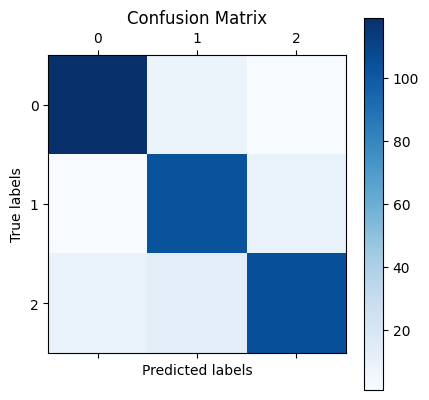

In [22]:
# Predict probabilities for each class
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()